# Prompt Chaining as a Powerful Agentic Workflow:

* Prompt chaining breaks a task into a sequence of steps.
* Each LLM call processes the output of the previous step.
* Programmatic checks can be added to intermediate steps for validation.
* Use "gates" to ensure the process remains on track.

⇒ This approach helps maintain accuracy and control in multi-step workflows.


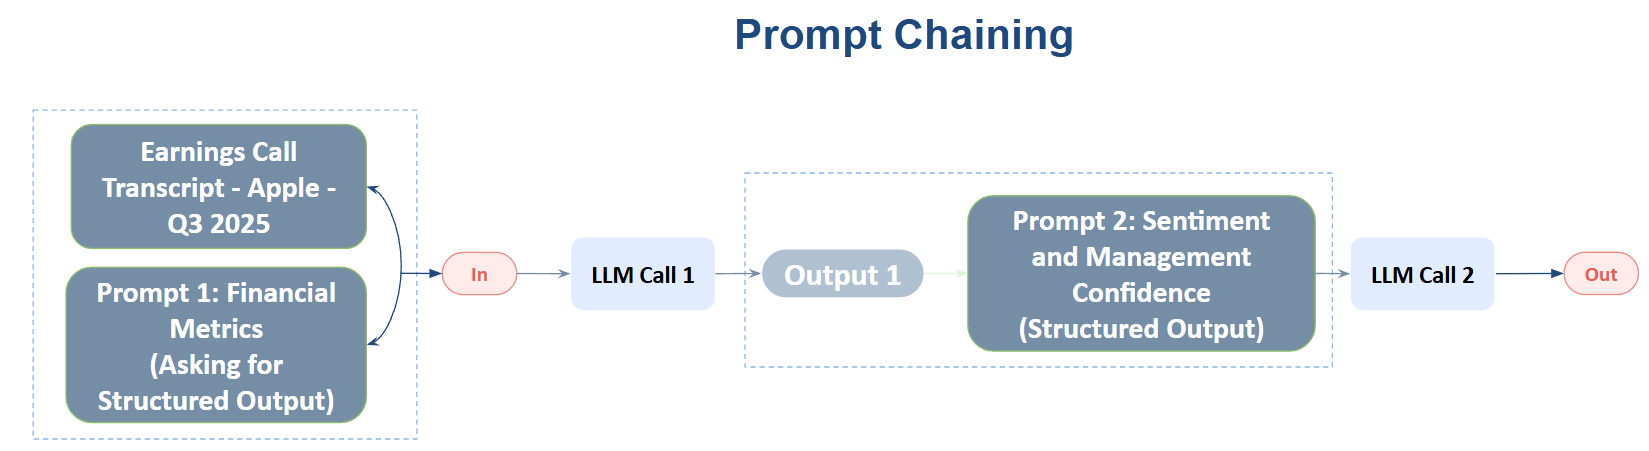

In [ ]:
from IPython.display import Image, display
image_path = path+"/agentic_workflow_prompt_chaining.png"
display(Image(filename=image_path))

**# How to extract key insights from an earnings call transcript step by step, using a structured output format and efficiently chaining the results:**


✅**Dataset**:

We'll use earnings call transcript of Apple Q3 2025.

🎯**Goals**:

Extract key information at each step to help understand the main numbers and insights discussed during the earnings call.

🛠️ **How**:

By using a **Prompt Chaining Agentic Workflow**, we can break down a large task into smaller sub-tasks, each focused on extracting specific key insights.

I'll create 2 sub-tasks:
- Prompt 1: Financial Metrics
- Prompt 2: Sentiment and Management Confidence

In each prompt, I ask the LLM to produce a strutured output, specifying the exact figures or insights I want to extract.


🤖 **LLM**:
I use Anthropic and call Clause 3.7 Sonnet




# Upload Earnings Call Transcript:

You can load earnings call transcript using **RapidAPI** that access to **Seeking Alpha** datasets

Or you can download the transcript uploaded to my github repo

In [ ]:
!wget  "https://raw.githubusercontent.com/hananedupouy/LLMs-in-Finance/refs/heads/main/Datasets/datasets_finance/apple_earnings_q3_2025.txt"  -O 'apple_earnings_call_transcript_q3_2025.txt'

In [ ]:
with open("apple_earnings_call_transcript_q3_2025.txt", "r") as file:
    clean_content = file.read()
print(clean_content)

## Count Number of tokens

I count the number of tokens to have an idea of the dataset size I'll be sending in my prompt to the LLM (and the associated cost):

In [ ]:
import tiktoken

def count_tokens(text: str, model_name: str = "gpt-3.5-turbo") -> int:
    """
    Counts the number of tokens in a given text string using a specified model's encoding.

    Args:
        text (str): The input string to tokenize.
        model_name (str): The name of the model to use for encoding.
                          Defaults to "gpt-3.5-turbo".

    Returns:
        int: The number of tokens in the text.
    """
    try:
        encoding = tiktoken.encoding_for_model(model_name)
    except KeyError:
        print(f"Warning: model {model_name} not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")

    num_tokens = len(encoding.encode(text))
    return num_tokens

tokens = count_tokens(clean_content)
print(f"The text has {tokens} tokens.")

The text has 9989 tokens.


# Specify your LLM

In [ ]:
%pip install anthropic -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.2/297.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
ANTHROPIC_API_KEY = userdata.get('CLAUDE_API_KEY')

In [ ]:
import json

In [ ]:
from anthropic import Anthropic

CLIENT = Anthropic(api_key=ANTHROPIC_API_KEY)

def llm_call(prompt: str, system_prompt: str = "", model="claude-3-7-sonnet-20250219") -> str:
    """
    Calls the model with the given prompt and returns the response.

    Args:
        prompt (str): The user prompt to send to the model.
        system_prompt (str, optional): The system prompt to send to the model. Defaults to "".
        model (str, optional): The model to use for the call. Defaults to "claude-3-7-sonnet-20250219".

    Returns:
        str: The response from the language model.
    """
    messages = [{"role": "user", "content": prompt}]
    response = CLIENT.messages.create(
        model=model,
        max_tokens=4096,
        system=system_prompt,
        messages=messages,
        temperature=0.1,
    )
    return response.content[0].text

# Prompt Chaining - Manuel Way

In this part, I'll create 2 prompts that will be chained with an LLM to produce a final answer:

* **Prompt 1** : It's responsible of extracting financial metrics, from the raw report content, following a well-defined json format

* **Prompt 2**: Based on the financial metrics extracted in step 1, this prompt asks the model to analyze sentiment and management confidence.

## Prompt 1: Financial Metrics

Extract **Financial Metrics** from the raw earnings call transcript following a detailled json format: 👇 🔽

In [ ]:
prompt_1 = f"""
From this earnings call transcript, extract all financial metrics and numbers mentioned.

Input data:
{clean_content}

Extract financial information into this exact JSON format:
{{
    "revenue_metrics": {{
        "total_revenue": {{
            "current_quarter": "amount and currency",
            "previous_year_same_quarter": "amount and currency",
            "growth_percentage": "percentage change"
        }},
        "segment_revenue": [
            {{
                "segment_name": "segment name",
                "current_revenue": "amount",
                "growth": "percentage"
            }}
        ]
    }},
    "profitability": {{
        "gross_margin": "percentage",
        "operating_margin": "percentage",
        "net_income": "amount",
        "earnings_per_share": "amount"
    }},
    "guidance": {{
        "next_quarter_revenue_range": "range provided",
        "full_year_guidance": "any full year guidance",
        "key_assumptions": ["list of guidance assumptions"]
    }},
    "other_metrics": {{
        "cash_position": "amount",
        "debt_levels": "amount",
        "share_repurchases": "amount",
        "dividend": "amount per share"
    }}
}}

Return only valid JSON, no additional text.
"""

In [ ]:
prompt_1

In [ ]:
results = llm_call(prompt_1)
results

'\n```json\n{\n    "revenue_metrics": {\n        "total_revenue": {\n            "current_quarter": "$94 billion",\n            "previous_year_same_quarter": "$85.5 billion (implied)",\n            "growth_percentage": "10%"\n        },\n        "segment_revenue": [\n            {\n                "segment_name": "iPhone",\n                "current_revenue": "$44.6 billion",\n                "growth": "13%"\n            },\n            {\n                "segment_name": "Mac",\n                "current_revenue": "$8 billion",\n                "growth": "15%"\n            },\n            {\n                "segment_name": "iPad",\n                "current_revenue": "$6.6 billion",\n                "growth": "-8%"\n            },\n            {\n                "segment_name": "Wearables, Home and Accessories",\n                "current_revenue": "$7.4 billion",\n                "growth": "-9%"\n            },\n            {\n                "segment_name": "Services",\n                "

Clean the string "results" generated by the LLM, to load it as a json, to be used in the following prompt: ⤵

In [ ]:
clean_string = results.replace("```json", "").replace("```", "").strip()

financial_data = json.loads(clean_string)
financial_data

{'revenue_metrics': {'total_revenue': {'current_quarter': '$94 billion',
   'previous_year_same_quarter': '$85.5 billion (implied)',
   'growth_percentage': '10%'},
  'segment_revenue': [{'segment_name': 'iPhone',
    'current_revenue': '$44.6 billion',
    'growth': '13%'},
   {'segment_name': 'Mac', 'current_revenue': '$8 billion', 'growth': '15%'},
   {'segment_name': 'iPad',
    'current_revenue': '$6.6 billion',
    'growth': '-8%'},
   {'segment_name': 'Wearables, Home and Accessories',
    'current_revenue': '$7.4 billion',
    'growth': '-9%'},
   {'segment_name': 'Services',
    'current_revenue': '$27.4 billion',
    'growth': '13%'},
   {'segment_name': 'Products',
    'current_revenue': '$66.6 billion',
    'growth': '8%'}]},
 'profitability': {'gross_margin': '46.5%',
  'operating_margin': 'not explicitly stated',
  'net_income': '$23.4 billion',
  'earnings_per_share': '$1.57'},
 'guidance': {'next_quarter_revenue_range': 'mid- to high single digits year-over-year growth'

## Prompt 2: Extract Sentiment and Management confidence

Extract **sentiment and management confidence** following a structured json format using the extracted financial metrics from the first step.

In [ ]:
prompt_2 =  f"""
Analyze the sentiment and management confidence based on these extracted financial metrics.

Financial data:
{json.dumps(financial_data, indent=2)}

Analyze sentiment patterns and return this exact JSON format:
{{
    "overall_sentiment_score": "1-10 scale where 10 is most positive",
    "confidence_indicators": {{
        "revenue_confidence": {{
            "score": "1-10 scale",
            "reasoning": "why this score based on growth patterns"
        }},
        "guidance_confidence": {{
            "score": "1-10 scale",
            "reasoning": "assessment based on guidance specificity"
        }},
        "margin_outlook": {{
            "score": "1-10 scale",
            "reasoning": "based on margin trends and comments"
        }}
    }},
    "risk_sentiment": {{
        "financial_stress_signals": ["list any concerning financial patterns"],
        "positive_momentum_signals": ["list encouraging financial trends"],
        "uncertainty_areas": ["areas where data shows uncertainty"]
    }},
    "comparative_analysis": {{
        "vs_previous_quarter": "better/worse/similar with reasoning",
        "vs_previous_year": "better/worse/similar with reasoning",
        "guidance_vs_actuals": "conservative/aggressive/realistic assessment"
    }}
}}

Base analysis purely on the financial patterns and numbers provided.
Return only valid JSON, no additional text.
"""

In [ ]:
results2 = llm_call(prompt_2)
results2

'```json\n{\n    "overall_sentiment_score": 7,\n    "confidence_indicators": {\n        "revenue_confidence": {\n            "score": 8,\n            "reasoning": "Strong 10% YoY total revenue growth with key segments (iPhone, Mac, Services) showing double-digit growth at 13-15%"\n        },\n        "guidance_confidence": {\n            "score": 6,\n            "reasoning": "Provided specific next quarter growth expectations and detailed assumptions, but used ranges rather than precise figures and didn\'t provide full-year guidance"\n        },\n        "margin_outlook": {\n            "score": 7,\n            "reasoning": "Strong current gross margin of 46.5% with guidance for similar levels (46-47%) in the next quarter"\n        }\n    },\n    "risk_sentiment": {\n        "financial_stress_signals": [\n            "iPad segment declined 8% YoY",\n            "Wearables, Home and Accessories segment declined 9% YoY",\n            "Expected tariff-related costs of $1.1 billion",\n    

In [ ]:
clean_string_2 = results2.replace("```json", "").replace("```", "").strip()

sentiment_data = json.loads(clean_string_2)
sentiment_data

{'overall_sentiment_score': 7,
 'confidence_indicators': {'revenue_confidence': {'score': 8,
   'reasoning': 'Strong 10% YoY total revenue growth with key segments (iPhone, Mac, Services) showing double-digit growth at 13-15%'},
  'guidance_confidence': {'score': 6,
   'reasoning': "Provided specific next quarter growth expectations and detailed assumptions, but used ranges rather than precise figures and didn't provide full-year guidance"},
  'margin_outlook': {'score': 7,
   'reasoning': 'Strong current gross margin of 46.5% with guidance for similar levels (46-47%) in the next quarter'}},
 'risk_sentiment': {'financial_stress_signals': ['iPad segment declined 8% YoY',
   'Wearables, Home and Accessories segment declined 9% YoY',
   'Expected tariff-related costs of $1.1 billion',
   'Relatively high debt level of $102 billion'],
  'positive_momentum_signals': ['10% overall revenue growth',
   '13% growth in iPhone revenue',
   '15% growth in Mac revenue',
   '13% growth in Services 

# Prompt Chaining: Global methods

In [ ]:
from typing import List
import json

def prompt_chainining(input: str, prompts: List[str]) -> str:
    """Chain multiple LLM calls sequentially, passing results between steps."""
    result = input
    for i, prompt in enumerate(prompts, 1):
        print(f"\nStep {i}:")
        result_int = llm_call(f"{prompt}\nInput: {result}")
        clean_json = result_int.replace("```json", "").replace("```", "").strip()
        result = json.loads(clean_json)
        print(result)
    return result

I slighlty modified the prompts to be aligned with my new functions:

In [ ]:
##Extract Financial Metrics based on the earnings call transcript (original input)
prompt_1 = f"""

Extract financial information into this exact JSON format:
{{
    "revenue_metrics": {{
        "total_revenue": {{
            "current_quarter": "amount and currency",
            "previous_year_same_quarter": "amount and currency",
            "growth_percentage": "percentage change"
        }},
        "segment_revenue": [
            {{
                "segment_name": "segment name",
                "current_revenue": "amount",
                "growth": "percentage"
            }}
        ]
    }},
    "profitability": {{
        "gross_margin": "percentage",
        "operating_margin": "percentage",
        "net_income": "amount",
        "earnings_per_share": "amount"
    }},
    "guidance": {{
        "next_quarter_revenue_range": "range provided",
        "full_year_guidance": "any full year guidance",
        "key_assumptions": ["list of guidance assumptions"]
    }},
    "other_metrics": {{
        "cash_position": "amount",
        "debt_levels": "amount",
        "share_repurchases": "amount",
        "dividend": "amount per share"
    }}
}}

Return only valid JSON, no additional text.

Extract all financial metrics and numbers mentioned above from this earnings call transcript:

"""

In [ ]:
##Extract Sentiment data
prompt_2 =  f"""
Analyze sentiment patterns and return this exact JSON format:
{{
    "overall_sentiment_score": "1-10 scale where 10 is most positive",
    "confidence_indicators": {{
        "revenue_confidence": {{
            "score": "1-10 scale",
            "reasoning": "why this score based on growth patterns"
        }},
        "guidance_confidence": {{
            "score": "1-10 scale",
            "reasoning": "assessment based on guidance specificity"
        }},
        "margin_outlook": {{
            "score": "1-10 scale",
            "reasoning": "based on margin trends and comments"
        }}
    }},
    "risk_sentiment": {{
        "financial_stress_signals": ["list any concerning financial patterns"],
        "positive_momentum_signals": ["list encouraging financial trends"],
        "uncertainty_areas": ["areas where data shows uncertainty"]
    }},
    "comparative_analysis": {{
        "vs_previous_quarter": "better/worse/similar with reasoning",
        "vs_previous_year": "better/worse/similar with reasoning",
        "guidance_vs_actuals": "conservative/aggressive/realistic assessment"
    }}
}}

Base analysis purely on the financial patterns and numbers provided.
Return only valid JSON, no additional text.

Analyze the sentiment and management confidence, mentionned above, based on these extracted financial metrics:
"""

In [ ]:
prompts_list = [prompt_1, prompt_2]

formatted_result = prompt_chainining(clean_content, prompts_list)


Step 1:
{'revenue_metrics': {'total_revenue': {'current_quarter': '$94 billion', 'previous_year_same_quarter': '$85.5 billion (implied from 10% growth)', 'growth_percentage': '10%'}, 'segment_revenue': [{'segment_name': 'iPhone', 'current_revenue': '$44.6 billion', 'growth': '13%'}, {'segment_name': 'Mac', 'current_revenue': '$8 billion', 'growth': '15%'}, {'segment_name': 'iPad', 'current_revenue': '$6.6 billion', 'growth': '-8%'}, {'segment_name': 'Wearables, Home and Accessories', 'current_revenue': '$7.4 billion', 'growth': '-9%'}, {'segment_name': 'Services', 'current_revenue': '$27.4 billion', 'growth': '13%'}]}, 'profitability': {'gross_margin': '46.5%', 'operating_margin': 'not explicitly stated', 'net_income': '$23.4 billion', 'earnings_per_share': '$1.57'}, 'guidance': {'next_quarter_revenue_range': 'mid- to high single digits year-over-year growth', 'full_year_guidance': 'not provided', 'key_assumptions': ['global tariff rates, policies and application remain in effect', 'g

In [ ]:
formatted_result

{'overall_sentiment_score': '8',
 'confidence_indicators': {'revenue_confidence': {'score': '8',
   'reasoning': 'Strong 10% overall revenue growth with key segments (iPhone, Mac, Services) showing 13-15% growth, though offset by declines in iPad and Wearables'},
  'guidance_confidence': {'score': '7',
   'reasoning': 'Specific next quarter guidance of mid-to-high single digit growth with detailed assumptions, though full year guidance is absent'},
  'margin_outlook': {'score': '8',
   'reasoning': 'Healthy gross margin of 46.5% and substantial net income of $23.4 billion indicate strong profitability'}},
 'risk_sentiment': {'financial_stress_signals': ['Declining iPad revenue (-8%)',
   'Declining Wearables, Home and Accessories revenue (-9%)',
   'Anticipated $1.1 billion in tariff-related costs'],
  'positive_momentum_signals': ['10% overall revenue growth',
   '13% growth in iPhone revenue',
   '15% growth in Mac revenue',
   '13% growth in Services revenue',
   'Strong cash positi